## Importar librerias y definición de la ruta  de trabajo (path)

In [58]:

import pandas as pd
import numpy as np
import os
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

# Tratamiento de datos
# ==============================================================================
import shap
from skforecast.utils import load_forecaster
from skforecast.utils import save_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import TimeSeriesFold
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
import skforecast
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import sklearn
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================


# Configuración warnings
# ==============================================================================
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

# Formato de los prints
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def headr(text):
    return ('\n'+color.UNDERLINE + text + color.END+'\n')


Versión skforecast: 0.15.1
Versión scikit-learn: 1.6.1
Versión pandas: 2.2.3
Versión numpy: 1.26.4


In [2]:
# Ingresa la ruta donde está el repositorio
ruta = 'c:/repo_remoto/'

## Integración

### Carga de archivos

In [ ]:
### Características Equipos

equipos = pd.read_csv(ruta + 'etapa4/data/Caracteristicas_Equipos.csv')
equipos_df = pd.DataFrame(equipos)
### Historicos Ordenes

ordenes = pd.read_csv(ruta + 'etapa4/data/Historicos_Ordenes.csv')
ordenes_df = pd.DataFrame(ordenes)
### Registros Condiciones

condiciones = pd.read_csv(ruta + 'etapa4/data/Registros_Condiciones.csv')
condiciones_df = pd.DataFrame(condiciones)

### Tratar equipos_df

In [ ]:
equipos_df

In [ ]:
# Mostrar el número de filas duplicadas
print("Número de filas duplicadas:", equipos_df.duplicated().sum())

# Mostrar todas las filas duplicadas considerando el índice como parte de los datos
duplicados = equipos_df[equipos_df.duplicated(keep=False)]
duplicados

### Tratar ordenes_df

In [ ]:
ordenes_df

In [ ]:
# Elimino ID_Orden, establezco Fecha como índice y le doy formato datetime
ordenes_df = ordenes_df.drop(columns=['ID_Orden']).set_index('Fecha')
ordenes_df.index = pd.to_datetime(ordenes_df.index)

In [ ]:
# Mostrar el número de filas duplicadas considerando el índice como parte de los datos
print("Número de filas duplicadas (incluyendo índice como columna):", ordenes_df.reset_index().duplicated(keep=False).sum())

# Mostrar todas las filas duplicadas considerando el índice como parte de los datos
duplicados = ordenes_df.reset_index()[ordenes_df.reset_index().duplicated(keep=False)]

### Tratar condiciones_df

In [ ]:
condiciones_df

In [ ]:
# Elimino ID_Registro, establezco Fecha como índice y le doy formato datetime
condiciones_df = condiciones_df.drop(columns=['ID_Registro']).set_index('Fecha')
condiciones_df.index = pd.to_datetime(condiciones_df.index)

In [ ]:
# Mostrar el número de filas duplicadas considerando el índice como parte de los datos
print("Número de filas duplicadas (incluyendo índice como columna):", condiciones_df.reset_index().duplicated(keep=False).sum())

# Mostrar todas las filas duplicadas considerando el índice como parte de los datos
duplicados = condiciones_df.reset_index()[condiciones_df.reset_index().duplicated(keep=False)]

### Merge

In [ ]:
# Asegurarse de que los índices sean de tipo datetime
ordenes_df.index = pd.to_datetime(ordenes_df.index)
condiciones_df.index = pd.to_datetime(condiciones_df.index)

# Mezclar los DataFrames basándose en el índice (fechas) y la columna 'ID_Equipo'
merged_df = pd.merge(
    ordenes_df.reset_index(),  # Reseteamos el índice temporal para incluirlo como columna
    condiciones_df.reset_index(),
    on=['Fecha', 'ID_Equipo'],  # Mezclamos por la fecha y el ID_Equipo
    how='outer'
)

# Volver a establecer 'Fecha' como índice
merged_df.set_index('Fecha', inplace=True)

# Mostrar el resultado
print(merged_df.info())

In [ ]:
# Relleno la columna Tipo_Mantenimiento vacías con Preventivo
merged_df['Tipo_Mantenimiento'] = merged_df['Tipo_Mantenimiento'].fillna('Preventivo')

In [ ]:
# Crear un diccionario con las ubicaciones conocidas por ID_Equipo
ubicaciones_por_equipo = ordenes_df[['ID_Equipo', 'Ubicacion']].dropna().drop_duplicates().set_index('ID_Equipo')['Ubicacion'].to_dict()

# Rellenar las filas vacías de Ubicacion en merged_df usando el diccionario
merged_df['Ubicacion'] = merged_df.apply(
    lambda row: ubicaciones_por_equipo.get(row['ID_Equipo'], row['Ubicacion']),
    axis=1
)

# Verificar si quedan valores vacíos en la columna Ubicacion
print("Valores vacíos restantes en 'Ubicacion':", merged_df['Ubicacion'].isna().sum())

In [ ]:
# Elimino columnas Costo_Mantenimiento y Duración_Horas
merged_df = merged_df.drop(columns=['Costo_Mantenimiento', 'Duracion_Horas'])

In [ ]:
# Combinar merged_df con equipos_df usando ID_Equipo como clave
merged_df = pd.merge(
    merged_df.reset_index(),  # Reseteamos el índice temporal para incluirlo como columna
    equipos_df,               # Información de los equipos
    on='ID_Equipo',           # Clave de unión
    how='left'                # Unión izquierda para mantener todas las filas de merged_df
)

# Volver a establecer 'Fecha' como índice
merged_df.set_index('Fecha', inplace=True)


In [ ]:
# Mostrar el resultado
merged_df

In [ ]:
# #Extraer el DataFrame unido a un archivo CSV

# merged_df = pd.DataFrame(merged_df)

# merged_df.to_csv(ruta + 'etapa4/output/merge_df.csv', index=True)


# print("El DataFrame merged_df se ha extraído a *.csv")

## Generar nuevas características

### Añado Frecuencia_Correctivo

In [ ]:
# Filtrar las filas donde Tipo_Mantenimiento es 'Correctivo'
correctivo_counts = merged_df[merged_df['Tipo_Mantenimiento'] == 'Correctivo'].groupby('ID_Equipo').size()

# Convertir a DataFrame y renombrar la columna
correctivo_counts = correctivo_counts.reset_index(name='Frecuencia_Correctivo')

# Añadir la columna al DataFrame merged_df
merged_df = merged_df.merge(correctivo_counts, on='ID_Equipo', how='left')

# Rellenar valores NaN con 0 (si algún ID_Equipo no tiene registros de 'Correctivo')
merged_df['Frecuencia_Correctivo'] = merged_df['Frecuencia_Correctivo'].fillna(0)

In [ ]:
merged_df

In [ ]:
# Tratamiento sesgo

merged_df["Frec_Correctivo"] = merged_df.Frecuencia_Correctivo.apply(np.log1p)


# Crear una comparación de gráficos
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(merged_df.Frecuencia_Correctivo, shade=True, ax=axs[0])
sns.kdeplot(merged_df.Frec_Correctivo, shade=True, ax=axs[1])

# Añadir títulos para mayor claridad
axs[0].set_title('Frecuencia_Correctivo Original')
axs[1].set_title('Frec_Correctivo Transformada con Log')

plt.tight_layout()
plt.show()

# Eliminar la columna Frecuencia_Correctivo por Frec_Correctivo
merged_df.drop(columns=["Frecuencia_Correctivo"], inplace=True)

### Añado Frecuencia_Preventivo

In [ ]:
# Filtrar las filas donde Tipo_Mantenimiento es 'Preventivo'
preventivo_counts = merged_df[merged_df['Tipo_Mantenimiento'] == 'Preventivo'].groupby('ID_Equipo').size()

# Convertir a DataFrame y renombrar la columna
preventivo_counts = preventivo_counts.reset_index(name='Frecuencia_Preventivo')

# Añadir la columna al DataFrame merged_df
merged_df = merged_df.merge(preventivo_counts, on='ID_Equipo', how='left')

# Rellenar valores NaN con 0 (si algún ID_Equipo no tiene registros de 'Preventivo')
merged_df['Frecuencia_Preventivo'] = merged_df['Frecuencia_Preventivo'].fillna(0)

In [ ]:
merged_df

In [ ]:
# Tratamiento sesgo

merged_df["Frec_Preventivo"] = merged_df.Frecuencia_Preventivo.apply(np.log1p)


# Crear una comparación de gráficos
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(merged_df.Frecuencia_Preventivo, shade=True, ax=axs[0])
sns.kdeplot(merged_df.Frec_Preventivo, shade=True, ax=axs[1])

# Añadir títulos para mayor claridad
axs[0].set_title('Frecuencia_Preventivo Original')
axs[1].set_title('Frec_Preventivo Transformada con Log')

plt.tight_layout()
plt.show()

# Eliminar la columna Frecuencia_Preventivo por Frec_Preventivo
merged_df.drop(columns=["Frecuencia_Preventivo"], inplace=True)

### Añadir Frecuencia Ubicación

In [ ]:
# Filtrar las filas donde Tipo_Mantenimiento es 'Correctivo'
ubicacion_counts = merged_df[merged_df['Tipo_Mantenimiento'] == 'Correctivo'].groupby('Ubicacion').size()

# Convertir a DataFrame y renombrar la columna
ubicacion_counts = ubicacion_counts.reset_index(name='Frecuencia_Ubicacion')

# Añadir la columna al DataFrame merged_df
merged_df = merged_df.merge(ubicacion_counts, on='Ubicacion', how='left')

# Rellenar valores NaN con 0 (si algún Ubicacion no tiene registros de 'Correctivo')
merged_df['Frecuencia_Ubicacion'] = merged_df['Frecuencia_Ubicacion'].fillna(0)

In [ ]:
merged_df

### Añadir Frecuencia Potencia_kW

In [ ]:
# Filtrar las filas donde Tipo_Mantenimiento es 'Correctivo'
Potencia_kW_counts = merged_df[merged_df['Tipo_Mantenimiento'] == 'Correctivo'].groupby('Potencia_kW').size()

# Convertir a DataFrame y renombrar la columna
Potencia_kW_counts = Potencia_kW_counts.reset_index(name='Frecuencia_Potencia_kW')

# Añadir la columna al DataFrame merged_df
merged_df = merged_df.merge(Potencia_kW_counts, on='Potencia_kW', how='left')

# Rellenar valores NaN con 0 (si algún Potencia_kW no tiene registros de 'Correctivo')
merged_df['Frecuencia_Potencia_kW'] = merged_df['Frecuencia_Potencia_kW'].fillna(0)

In [ ]:
merged_df

In [ ]:
# Tratamiento sesgo

merged_df["Frec_Potencia_kW"] = merged_df.Frecuencia_Potencia_kW.apply(np.log1p)


# Crear una comparación de gráficos
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(merged_df.Frecuencia_Potencia_kW, shade=True, ax=axs[0])
sns.kdeplot(merged_df.Frec_Potencia_kW, shade=True, ax=axs[1])

# Añadir títulos para mayor claridad
axs[0].set_title('Frecuencia_Potencia_kW Original')
axs[1].set_title('Frec_Potencia_kW Transformada con Log')

plt.tight_layout()
plt.show()

# Eliminar la columna Frecuencia_Potencia_kW por Frec_Preventivo
merged_df.drop(columns=["Frecuencia_Potencia_kW"], inplace=True)

### Almacenamiento

In [ ]:
# Extraer el DataFrame a un archivo CSV

merged_df.to_csv(ruta + 'etapa3/output/Mantenimiento.csv', index=False)


print("El DataFrame merged_df se ha extraído a *.csv")

## Analisis y exportación Profiling

In [ ]:
merged_df = pd.read_csv(ruta + 'Etapa4/output/merge_df.csv')

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(merged_df, title="Mantenimiento Profiling Report")

In [ ]:
profile.to_notebook_iframe()

In [ ]:
profile.to_file(ruta + 'Etapa4/output/Mantenimiento.html')

## Preprocesado

In [7]:
mantenimiento_df = pd.read_csv(ruta + 'Etapa4/output/merge_df.csv')

In [8]:
mantenimiento_df_1 = mantenimiento_df[mantenimiento_df['ID_Equipo'] == 300].copy()
mantenimiento_df_1

,Fecha,ID_Equipo,Tipo_Mantenimiento,Ubicacion,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
299,2021-01-01,300,Preventivo,Ubicacion_C,66.751462,5.159466,628,Compresor,Fabricante_C,Modelo_1,369,568
799,2021-01-02,300,Preventivo,Ubicacion_C,52.015960,5.612254,638,Compresor,Fabricante_C,Modelo_1,369,568
1299,2021-01-03,300,Preventivo,Ubicacion_C,32.920433,2.692280,654,Compresor,Fabricante_C,Modelo_1,369,568
1799,2021-01-04,300,Preventivo,Ubicacion_C,59.591049,0.682017,672,Compresor,Fabricante_C,Modelo_1,369,568
2299,2021-01-05,300,Preventivo,Ubicacion_C,36.557020,5.380131,680,Compresor,Fabricante_C,Modelo_1,369,568
...,...,...,...,...,...,...,...,...,...,...,...,...
729546,2024-12-27,300,Correctivo,Ubicacion_C,46.747732,0.299322,22,Compresor,Fabricante_C,Modelo_1,369,568
730046,2024-12-28,300,Preventivo,Ubicacion_C,86.514565,1.161832,29,Compresor,Fabricante_C,Modelo_1,369,568
730546,2024-12-29,300,Correctivo,Ubicacion_C,35.849285,7.549357,23,Compresor,Fabricante_C,Modelo_1,369,568
731048,2024-12-30,300,Preventivo,Ubicacion_C,63.646322,4.029486,35,Compresor,Fabricante_C,Modelo_1,369,568


In [9]:
mantenimiento_df_1['Fecha'] = pd.to_datetime(mantenimiento_df_1['Fecha'], format='%Y-%m-%d')
mantenimiento_df_1 = mantenimiento_df_1.set_index('Fecha')

In [10]:
# Eliminar duplicados en el índice para evitar errores
mantenimiento_df_1 = mantenimiento_df_1[~mantenimiento_df_1.index.duplicated(keep='first')]

mantenimiento_df_1 = mantenimiento_df_1.asfreq('D')  # Convierte Timeseries a frecuencia especificada.
mantenimiento_df_1 = mantenimiento_df_1.sort_index()

In [11]:
# Sumatorio de filas duplicadas en mantenimiento_df
print("Sumatorio de filas duplicadas en mantenimiento_df:", mantenimiento_df_1.duplicated().sum())

Sumatorio de filas duplicadas en mantenimiento_df: 0


In [12]:
print(f'Número de filas con missing values: {mantenimiento_df_1.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [13]:
# Verificar que un índice temporal está completo

fecha_inicio = mantenimiento_df_1.index.min()
fecha_fin = mantenimiento_df_1.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=mantenimiento_df_1.index.freq)

print(f"Índice completo: {(mantenimiento_df_1.index == date_range_completo).all()}")

Índice completo: True


In [14]:
mantenimiento_df_1

,ID_Equipo,Tipo_Mantenimiento,Ubicacion,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Tipo_Equipo,Fabricante,Modelo,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,,,,,,
2021-01-01,300,Preventivo,Ubicacion_C,66.751462,5.159466,628,Compresor,Fabricante_C,Modelo_1,369,568
2021-01-02,300,Preventivo,Ubicacion_C,52.015960,5.612254,638,Compresor,Fabricante_C,Modelo_1,369,568
2021-01-03,300,Preventivo,Ubicacion_C,32.920433,2.692280,654,Compresor,Fabricante_C,Modelo_1,369,568
2021-01-04,300,Preventivo,Ubicacion_C,59.591049,0.682017,672,Compresor,Fabricante_C,Modelo_1,369,568
2021-01-05,300,Preventivo,Ubicacion_C,36.557020,5.380131,680,Compresor,Fabricante_C,Modelo_1,369,568
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,300,Correctivo,Ubicacion_C,46.747732,0.299322,22,Compresor,Fabricante_C,Modelo_1,369,568
2024-12-28,300,Preventivo,Ubicacion_C,86.514565,1.161832,29,Compresor,Fabricante_C,Modelo_1,369,568
2024-12-29,300,Correctivo,Ubicacion_C,35.849285,7.549357,23,Compresor,Fabricante_C,Modelo_1,369,568


In [15]:
# Elimino ID_Orden, establezco Fecha como índice y le doy formato datetime
mantenimiento_df_1 = mantenimiento_df_1.drop(
    columns=['ID_Equipo','Ubicacion', 'Tipo_Equipo', 'Fabricante', 'Modelo', 'Potencia_kW', 'Horas_Recomendadas_Revision'])

In [16]:
mantenimiento_df_1

,Tipo_Mantenimiento,Temperatura_C,Vibracion_mm_s,Horas_Operativas
Fecha,,,,
2021-01-01,Preventivo,66.751462,5.159466,628
2021-01-02,Preventivo,52.015960,5.612254,638
2021-01-03,Preventivo,32.920433,2.692280,654
2021-01-04,Preventivo,59.591049,0.682017,672
2021-01-05,Preventivo,36.557020,5.380131,680
...,...,...,...,...
2024-12-27,Correctivo,46.747732,0.299322,22
2024-12-28,Preventivo,86.514565,1.161832,29
2024-12-29,Correctivo,35.849285,7.549357,23


In [17]:
from sklearn.preprocessing import LabelEncoder

# Crear un codificador para la columna Tipo_Mantenimiento
label_encoder = LabelEncoder()

# Transformar la columna Tipo_Mantenimiento en valores numéricos
mantenimiento_df_1['Tipo_Mantenimiento'] = label_encoder.fit_transform(mantenimiento_df_1['Tipo_Mantenimiento'])

# Verificar la transformación
mantenimiento_df_1

,Tipo_Mantenimiento,Temperatura_C,Vibracion_mm_s,Horas_Operativas
Fecha,,,,
2021-01-01,1,66.751462,5.159466,628
2021-01-02,1,52.015960,5.612254,638
2021-01-03,1,32.920433,2.692280,654
2021-01-04,1,59.591049,0.682017,672
2021-01-05,1,36.557020,5.380131,680
...,...,...,...,...
2024-12-27,0,46.747732,0.299322,22
2024-12-28,1,86.514565,1.161832,29
2024-12-29,0,35.849285,7.549357,23


Fechas train : 2021-01-01 00:00:00 --- 2024-08-03 00:00:00  (n=1311)
Fechas test  : 2024-08-04 00:00:00 --- 2024-12-31 00:00:00  (n=150)


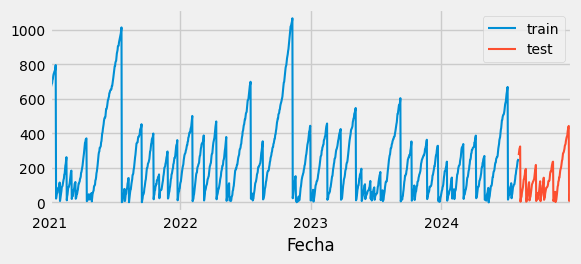

In [37]:
# Separación datos train-test

steps = 150
datos_train = mantenimiento_df_1[:-steps]
datos_test  = mantenimiento_df_1[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
ax.legend();

In [59]:
# Crear y entrenar forecaster

forecaster = ForecasterDirect(
    regressor=Lasso(random_state=123),
    transformer_y=StandardScaler(),
    steps=150,
    lags=10
    )

forecaster.fit(y=datos_train['Horas_Operativas'])
forecaster

================ 
ForecasterDirect 
================ 
Regressor: Lasso 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: None 
Window size: 10 
Maximum steps to predict: 150 
Exogenous included: False 
Exogenous names: None 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-08-03 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000,
    'positive': False, 'precompute': False, 'random_state': 123, 'selection':
    'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-24 13:22:51 
Last fit date: 2025-04-24 13:22:52 
Skforecast version: 0.15.1 
Python version: 3.10.11 
Forecaster id: None

In [60]:
# Predicciones

steps = 150
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2024-08-04    235.705729
2024-08-05    235.122396
2024-08-06    234.537326
2024-08-07    233.955729
2024-08-08    233.380208
Freq: D, Name: pred, dtype: float64

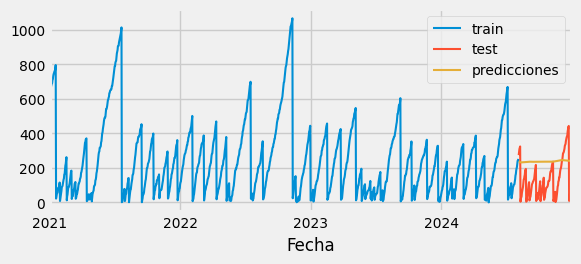

In [61]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [62]:
# Error test
error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

# Varianza de los valores reales
varianza = datos_test['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza de los valores reales: {varianza}")

Error de test (mse): 22978.130639899613
Varianza de los valores reales: 12234.045861297536


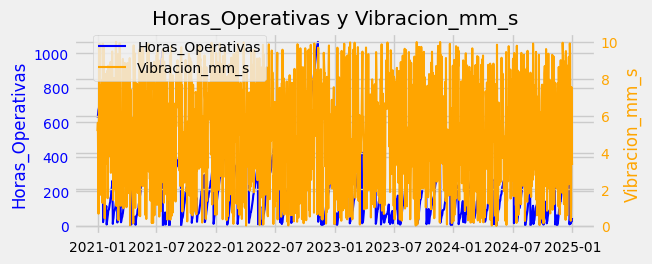

In [23]:
# Preparación del dato con escalas de y independientes

fig, ax1 = plt.subplots(figsize=(6, 2.5))

# Primer eje y para 'Horas_Operativas'
ax1.plot(mantenimiento_df_1.index, mantenimiento_df_1['Horas_Operativas'], label='Horas_Operativas', color='blue')
ax1.set_ylabel('Horas_Operativas', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Segundo eje y para 'Vibracion_mm_s'
ax2 = ax1.twinx()
ax2.plot(mantenimiento_df_1.index, mantenimiento_df_1['Vibracion_mm_s'], label='Vibracion_mm_s', color='orange')
ax2.set_ylabel('Vibracion_mm_s', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Leyenda y título
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Horas_Operativas y Vibracion_mm_s')
plt.show()

In [63]:
# Crear y entrenar forecaster

forecaster = ForecasterDirect(
    regressor=Lasso(random_state=123),
    transformer_y=StandardScaler(),
    steps=150,
    lags=10
    )

forecaster.fit(y=datos_train['Horas_Operativas'], exog=datos_train['Vibracion_mm_s'])

forecaster

================ 
ForecasterDirect 
================ 
Regressor: Lasso 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: None 
Window size: 10 
Maximum steps to predict: 150 
Exogenous included: True 
Exogenous names: Vibracion_mm_s 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-08-03 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000,
    'positive': False, 'precompute': False, 'random_state': 123, 'selection':
    'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-24 13:23:17 
Last fit date: 2025-04-24 13:23:18 
Skforecast version: 0.15.1 
Python version: 3.10.11 
Forecaster id: None

In [64]:
# Predicciones

predicciones = forecaster.predict(steps=steps, exog=datos_test['Vibracion_mm_s'])

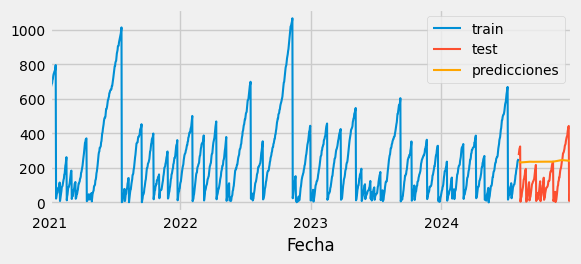

In [65]:
# Gráfico predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')

predicciones.plot(ax=ax, label='predicciones', color='orange')
ax.legend();

In [66]:
# Specify the step for which you want to calculate feature importances
step = 1  # Replace with the desired step number
importancia = forecaster.get_feature_importances(step=step)
importancia

,feature,importance
0,lag_1,0.0
1,lag_2,0.0
2,lag_3,0.0
3,lag_4,0.0
4,lag_5,0.0
5,lag_6,0.0
6,lag_7,0.0
7,lag_8,0.0
8,lag_9,0.0
9,lag_10,0.0


In [68]:
# Búsqueda de hiperparámetros

from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterDirect(
    regressor=Lasso(random_state=123),
    transformer_y=StandardScaler(),
    steps=150,
    lags=50  # Este valor será remplazado en el grid search
)

cv = TimeSeriesFold(
    steps=150,
    initial_train_size=int(len(datos_train) * 0.5),
    fixed_train_size=False,
    refit=False,
)

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 20, 50]

resultados_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=datos_train['Horas_Operativas'],
    cv=cv,
    param_grid=param_grid,
    lags_grid=lags_grid,
    metric='mean_squared_error',
    return_best=True,
    n_jobs='auto',
    verbose=False
)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 35871.54741824673


In [69]:
# Crear y entrenar forecaster

forecaster = ForecasterDirect(
    regressor=Lasso(alpha= 1e-05, random_state=123),
    transformer_y=StandardScaler(),
    steps=150,
    lags=5
    )

forecaster.fit(y=datos_train['Horas_Operativas'], exog=datos_train['Vibracion_mm_s'])

forecaster

================ 
ForecasterDirect 
================ 
Regressor: Lasso 
Lags: [1 2 3 4 5] 
Window features: None 
Window size: 5 
Maximum steps to predict: 150 
Exogenous included: True 
Exogenous names: Vibracion_mm_s 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2024-08-03 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1e-05, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000,
    'positive': False, 'precompute': False, 'random_state': 123, 'selection':
    'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-24 13:24:26 
Last fit date: 2025-04-24 13:24:27 
Skforecast version: 0.15.1 
Python version: 3.10.11 
Forecaster id: None

In [70]:
# Predicciones

predicciones = forecaster.predict(steps=steps, exog=datos_test['Vibracion_mm_s'])

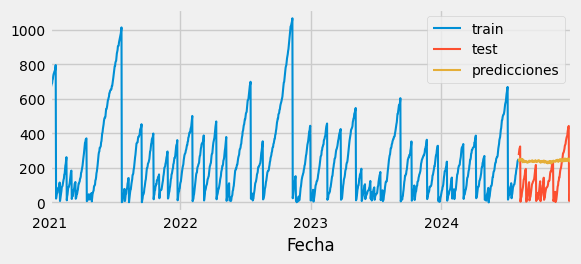

In [71]:
# Predicciones

predicciones = forecaster.predict(exog=datos_test['Vibracion_mm_s'])

# Gráfico predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [72]:
# Error test
error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

# Varianza de los valores reales
varianza = datos_test['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza de los valores reales: {varianza}")

Error de test (mse): 23421.017515818086
Varianza de los valores reales: 12234.045861297536


In [73]:
# Backtesting

cv = TimeSeriesFold(
    steps=20 * 3,
    initial_train_size=len(mantenimiento_df_1) - 12 * 9,
    fixed_train_size=False,
    refit=True,
)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=mantenimiento_df_1['Horas_Operativas'],
    cv=cv,
    metric='mean_squared_error',
    verbose=True
)
metrica

Information of folds
--------------------
Number of observations used for initial training: 1353
Number of observations used for backtesting: 108
    Number of folds: 2
    Number skipped folds: 0 
    Number of steps per fold: 60
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 48 observations.

Fold: 0
    Training:   2021-01-01 00:00:00 -- 2024-09-14 00:00:00  (n=1353)
    Validation: 2024-09-15 00:00:00 -- 2024-11-13 00:00:00  (n=60)
Fold: 1
    Training:   2021-01-01 00:00:00 -- 2024-11-13 00:00:00  (n=1413)
    Validation: 2024-11-14 00:00:00 -- 2024-12-31 00:00:00  (n=48)



  0%|          | 0/2 [00:00<?, ?it/s]

,mean_squared_error
0,18184.506301


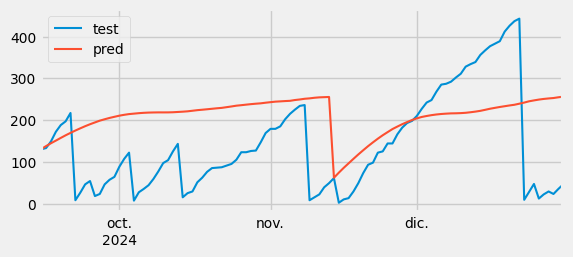

In [74]:
# Gráfico de predicciones de backtest vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
mantenimiento_df_1.loc[predicciones_backtest.index, 'Horas_Operativas'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend()

### Explorar

In [ ]:
mantenimiento_df.shape

In [ ]:
mantenimiento_df.describe()

In [ ]:
mantenimiento_df.describe(include=object)

In [ ]:
mantenimiento_df.info()

### Valores faltantes

In [ ]:
# Datos vacios
print('Datos vacios en mantenimiento\n',mantenimiento_df.isna().sum())

In [ ]:
# Rellenar valores faltantes en columnas numéricas con la media
numerical_columns = mantenimiento_df.select_dtypes(include=['float64', 'int64']).columns
mantenimiento_df[numerical_columns] = mantenimiento_df[numerical_columns].fillna(mantenimiento_df[numerical_columns].mean())

# Rellenar valores faltantes en columnas categóricas con la moda
categorical_columns = mantenimiento_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    mantenimiento_df[column] = mantenimiento_df[column].fillna(mantenimiento_df[column].mode()[0])

mantenimiento_df.info()

In [ ]:
# Mostrar las filas que tienen valores vacíos
filas_vacias = mantenimiento_df[mantenimiento_df.isna().any(axis=1)]
filas_vacias

### Outliers

In [ ]:
# Extraer columnas numéricas y categóricas
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(mantenimiento_df)
categorical_columns = categorical_columns_selector(mantenimiento_df)

print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)

In [ ]:
# Outliers

# identificación
IQR = mantenimiento_df[numerical_columns].quantile(0.75) - mantenimiento_df[numerical_columns].quantile(0.25)
lower_bound = mantenimiento_df[numerical_columns].quantile(0.25) - (IQR * 3)
upper_bound = mantenimiento_df[numerical_columns].quantile(0.75) + (IQR * 3)

print(headr('lower_bound'),lower_bound)
print(headr('upper_bound'),upper_bound)

outliers = mantenimiento_df[numerical_columns][(mantenimiento_df[numerical_columns] < lower_bound) | (mantenimiento_df[numerical_columns] > upper_bound)]

print(headr("Outliers:"))
outliers.count()

### Duplicados

In [ ]:
# Mostrar todas las filas duplicadas
print('\nSumatorio duplicados en mantenimiento', mantenimiento_df.duplicated().sum())
mantenimiento_df[mantenimiento_df.duplicated(keep=False)]

### Tratamiento tipo de columnas

In [ ]:
# Extraer columnas numéricas y categóricas
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(mantenimiento_df)
categorical_columns = categorical_columns_selector(mantenimiento_df)

print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)

In [ ]:
# Transformamos columnas categoricas en valores numéricos

from sklearn.preprocessing import LabelEncoder

mantenimiento_dff = mantenimiento_df.copy()
mantenimiento_dff[categorical_columns] = mantenimiento_dff[categorical_columns].apply(LabelEncoder().fit_transform)   
mantenimiento_dff.head()

### Seleccionamos características más relevantes

In [ ]:
# Evaluamos la aportación de cada columna
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X= mantenimiento_dff.drop(target_column, axis=1)
y = mantenimiento_dff[target_column]

fvalue_selector = SelectKBest(f_classif, k=2)

X_kbest = fvalue_selector.fit(X,y)

feature_scores = pd.DataFrame({"Feature": X.columns,"Score": X_kbest.scores_}).sort_values(by="Score", ascending=False)

print(headr("Feature scores"))
round(feature_scores,2)

In [ ]:
# Seleccionar las 5 características más relevantes
top_features = feature_scores.head(9)['Feature']
X_selected = X[top_features]

print("Características seleccionadas:")
print(top_features)


In [ ]:
# Seleccionar las columnas más relevantes y la columna target_column
relevant_columns = top_features.tolist() + [target_column]

# Actualizar mantenimiento_const con las columnas seleccionadas
mantenimiento_const = mantenimiento_dff[relevant_columns]

# Mostrar las primeras filas del DataFrame actualizado
mantenimiento_const.head()

In [ ]:
# Ver proporciones nuevamente

# import matplotlib.pyplot as plt
# import seaborn as sns

# %matplotlib inline


# features = X.columns
# num_features = len(features)

# for i, feature in enumerate(features):
#     print(headr(f"Graficando: {feature}"))
#     sns.barplot(x=feature, y=target_column, data=mantenimiento_dff)
#     plt.title(f"Tasa de {target_column} por {feature}")
#     plt.xlabel(feature)
#     plt.ylabel(target_column)
#     plt.show()

### Eliminar características constantes

In [ ]:
# Calcular la varianza de cada columna
column_variances = X.var()

# Crear un DataFrame para visualizar mejor los resultados
variance_df = pd.DataFrame({
    "Feature": column_variances.index,
    "Variance": column_variances.values
}).sort_values(by="Variance", ascending=False)

# Mostrar las varianzas ordenadas de mayor a menor
print("Varianza de cada columna:")
print(variance_df)

In [ ]:
# # Seleccionar características con varianza mayor a 5 o el valor que se desee, excluyendo target_column

# from sklearn.feature_selection import VarianceThreshold


# # Aplicar VarianceThreshold
# sel = VarianceThreshold(threshold=5)
# sel.fit(X)

# # Obtener las columnas que no son constantes
# no_constant_columns = X.columns[sel.get_support()]
# constant_columns = X.columns.drop(no_constant_columns)

# print(headr("Columnas constantes:"), constant_columns)

# # Actualizar mantenimiento_const excluyendo las columnas constantes, pero manteniendo target_column
# mantenimiento_const = mantenimiento_const.drop(columns=[col for col in constant_columns if col != target_column])
# print(headr("Columnas finales:"), mantenimiento_const.columns)

### Separamos el target

In [ ]:
# Separar características y target
X = mantenimiento_const.drop(target_column, axis=1)     #df_mantenimiento.drop(target_column, axis=1)
y = mantenimiento_const[target_column] # Se coje el target

In [ ]:
X.shape

### Preparar para entrenamiento

In [ ]:
# Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)

## Candidatos

A partir del análisis previo:

1. `LogisticRegression`
2. `RandomForestClassifier` 
3. `DecisionTreeClassifier`
4. `KNeighborsClassifier`

### Piplines

In [ ]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)

In [ ]:
preprocessor = ColumnTransformer(
    [
        ('numerical', StandardScaler(), numerical_columns),
        ('categorical', OneHotEncoder(), categorical_columns)
    ])

pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression())]),
    "RandomForestClassifier": Pipeline([('preprocessor', preprocessor),('classifier', RandomForestClassifier())]),
    "DecisionTreeClassifier": Pipeline([('preprocessor', preprocessor),('classifier', DecisionTreeClassifier())]),
    "KNeighborsClassifier": Pipeline([('preprocessor', preprocessor),('classifier', KNeighborsClassifier(n_neighbors=2, metric= 'euclidean', weights= 'distance'))]),
    #"SVC": Pipeline([('preprocessor', preprocessor),('classifier', SVC())]),
    #"GradientBoostingClassifier": Pipeline([('preprocessor', preprocessor),('classifier', GradientBoostingClassifier(n_estimators=500))]),
 
}

### CV

In [ ]:
def cv_train(name, pipeline, cv):
    print(headr(f"Entrenar {name}"))
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring="accuracy", return_estimator=True, return_train_score=True)
    trained_model = cv_results["estimator"][0]
    scores = pd.DataFrame(cv_results)

    print("test score (mean-std): {0:.2f} - {1:.2f}".format(scores["test_score"].mean(), scores["test_score"].std()))
    print("train score (mean-std): {0:.2f} - {1:.2f}".format(scores["train_score"].mean(), scores["train_score"].std()))
    print("params:", pipeline.named_steps.get("classifier").get_params())

    y_pred = trained_model.predict(X_test)
    f1 = f1_score(y_test, y_pred) #

    return {"acc": round(scores["test_score"].mean(), 2), "f1": round(f1, 2),}

In [ ]:
cvss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

results = {}

for name, pipeline in pipelines.items():
    results[name] = cv_train(name, pipeline, cvss)

print(headr("Resultados:"))
results_df=pd.DataFrame(results)
results_df

### Curva de aprendizaje

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve


In [ ]:
# Curvas de aprendizaje

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

def generate_learning_curves(name, pipeline, X, y, train_sizes):
    results = learning_curve(pipeline, X, y, train_sizes=train_sizes,
                             cv=cvss, scoring='accuracy')
    
    train_size, train_scores, test_scores = results[:3]

    # graficar la curva.
    plt.errorbar(train_size, train_scores.mean(axis=1),
                 yerr=train_scores.std(axis=1), label="Accuracy de entrenamiento", color='blue', linestyle='--', marker=None)
    plt.errorbar(train_size, test_scores.mean(axis=1),
                 yerr=test_scores.std(axis=1), label="Accuracy de prueba", color='red', linestyle='-', marker=None)
    
    # Posicionar la leyenda en el centro a la derecha
    plt.legend(loc='lower right')

    plt.xscale("linear")
    plt.xlabel("Número de muestras en el conjunto de entrenamiento")
    plt.ylabel("Accuracy")
    plt.title("Curva de aprendizaje para {name}".format(name=name))
    
    # Ajusta según el rango esperado de los valores
    plt.ylim(0, 1)
    
    
   

    plt.show()

In [ ]:
# Mostramos gráficas

for pipeline_name, pipeline_obj in pipelines.items():
    generate_learning_curves(pipeline_name, pipeline_obj, X, y, train_sizes)

### Curva validación

In [ ]:

# Curvas de validación

def generate_validation_curves(name, pipeline, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
        pipeline, X, y, param_name=param_name, param_range=param_range,
        cv=cvss, scoring="accuracy")

    # graficar la curva.
    plt.plot(param_range, train_scores.mean(
        axis=1), label="Error de entrenamiento", color='blue', linestyle='--')
    plt.plot(param_range, test_scores.mean(axis=1), label="Error de prueba", color='red', linestyle='-')
    plt.legend()

    plt.xlabel("Valor del ({param_name})".format(
        param_name=param_name))
    plt.ylabel("Accuracy")
    plt.title("Curva de validación para {name}".format(name=name))
    plt.ylim(0, 2)  # Ajusta según el rango esperado de los valores

    plt.show()


In [ ]:
# Mostramos gráficas

pname = 'LogisticRegression'
Cs = [0.1, 10, 20]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__C', Cs)

In [ ]:
pname = 'RandomForestClassifier'
min_samples_split = [1, 0.1, 0.01, 0.001]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__min_samples_split', min_samples_split)

In [ ]:
pname = 'DecisionTreeClassifier'
max_depth = [1,5,10,150]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__max_depth', max_depth)

In [ ]:
pname = 'KNeighborsClassifier'
n_neighbors = [1, 5, 10, 15, 20]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__n_neighbors', n_neighbors)

### Afinar hiperparámentros

In [ ]:
from sklearn.model_selection import GridSearchCV

pname = 'LogisticRegression'

param_grid = {
    'classifier__C': [7.5, 50, 70],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag, saga']
}

grid_search = GridSearchCV(
    pipelines[pname], param_grid, cv=cvss, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")

In [ ]:
from sklearn.model_selection import GridSearchCV

pname = 'RandomForestClassifier'

param_grid = {
    'classifier__n_estimators': [50, 70, 120],
    'classifier__min_samples_split': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(
    pipelines[pname], param_grid, cv=cvss, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")

In [ ]:
from sklearn.model_selection import GridSearchCV

pname = 'DecisionTreeClassifier'

param_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__min_samples_split': [0.5, 1.5, 2, 3]
}

grid_search = GridSearchCV(
    pipelines[pname], param_grid, cv=cvss, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")

In [ ]:
from sklearn.model_selection import GridSearchCV

pname = 'KNeighborsClassifier'

param_grid = {
    'classifier__n_neighbors': [0, 2, 5, 7],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'classifier__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    pipelines[pname], param_grid, cv=cvss, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")

### re-entrenar + re-evaluar

In [ ]:
preprocessor = ColumnTransformer(
    [
        ('numerical', StandardScaler(), numerical_columns),
        ('categorical', OneHotEncoder(), categorical_columns)
    ])

pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression(C=7.5,penalty='l2',solver='newton-cg'))]),
    "RandomForestClassifier": Pipeline([('preprocessor', preprocessor),('classifier', RandomForestClassifier(min_samples_split= 2, n_estimators= 100))]),
    "DecisionTreeClassifier": Pipeline([('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(criterion='gini',min_samples_leaf=2))]),
    "KNeighborsClassifier": Pipeline([('preprocessor', preprocessor),('classifier', KNeighborsClassifier(n_neighbors=2, metric= 'euclidean', weights= 'distance'))]),
 }

In [ ]:
results_final = {}

for name, pipeline in pipelines.items():
    results_final[name] = cv_train(name, pipeline, cvss)

## Resumen del Notebook

Este notebook realiza un análisis completo de datos relacionados con el mantenimiento de equipos, desde la preparación de los datos hasta la evaluación de modelos de clasificación.
A continuación, se resume cada sección:

1. **Carga y preparación de datos**
Se importan librerías necesarias y herramientas de scikit-learn.
Se cargan varios archivos CSV relacionados con características de equipos, históricos de órdenes y registros de condiciones.
Se procesan los datos:
Se eliminan columnas irrelevantes.
Se convierten índices a formato de fecha.
Se agrupan y combinan los datos en un único DataFrame (merged_df).
Se añaden nuevas características como frecuencias de mantenimiento correctivo, preventivo, por ubicación y potencia.

2. **Limpieza de datos**
Se verifican y rellenan valores faltantes.
Se eliminan duplicados.
Se verifican outliers.
Se transforman columnas categóricas en valores numéricos usando LabelEncoder.

3. **Selección de características**
Se evalúa la importancia de las características utilizando SelectKBest y se seleccionan las más relevantes.
Se eliminan características con baja varianza.

4. **División de datos**
Se separan los datos en características (X) y la variable objetivo (y), que es el tipo de mantenimiento.
Se dividen los datos en conjuntos de entrenamiento y prueba (80%-20%).

5. **Modelos candidatos**
Se definen cuatro modelos de clasificación como candidatos:
LogisticRegression
RandomForestClassifier
DecisionTreeClassifier
KNeighborsClassifier
Se crean pipelines para cada modelo, incluyendo preprocesamiento (escalado y codificación).

6. **Evaluación inicial**
Se realiza validación cruzada para evaluar el desempeño de cada modelo en términos de precisión (accuracy) y puntaje F1.
Se generan curvas de aprendizaje para analizar el comportamiento de los modelos con diferentes tamaños de datos de entrenamiento.

7. **Curvas de validación**
Se generan curvas de validación para ajustar hiperparámetros clave de los modelos, como C para regresión logística, min_samples_split para Random Forest, y otros.

8. **Afinación de hiperparámetros**
Se utiliza GridSearchCV para buscar los mejores hiperparámetros para cada modelo.

9. **Reentrenamiento y evaluación final**
Los modelos se reentrenan con los mejores hiperparámetros encontrados.
Se evalúan nuevamente para comparar su desempeño final.

**Resultados**

El notebook permite identificar el modelo con mejor desempeño basado en las métricas de validación cruzada y las curvas de aprendizaje.
Los modelos DecisionTreeClassifier y KNeighborsClassifier parecen tener un desempeño destacado en las evaluaciones iniciales.
En resumen, este notebook realiza un flujo completo de análisis de datos, selección de características, entrenamiento y evaluación de modelos de clasificación para predecir el tipo de mantenimiento de equipos.

## Conclusiones y elección de MODELO

**Resumen y elección del modelo**

1. Logistic Regression:

- Curva de aprendizaje: La accuracy de entrenamiento y prueba se mantienen constantes alrededor de 0.63, indicando que el modelo no mejora con más datos de entrenamiento.

    Conclusión: Este modelo está subajustado, ya que no alcanza el objetivo de accuracy ≥ 0.80 ni el f1 ≥ 0.75.

2. Random Forest Classifier:

- Curva de aprendizaje: La accuracy de prueba aumenta con más datos de entrenamiento, acercándose a la accuracy de entrenamiento.

    Conclusión: Este modelo muestra una tendencia positiva y es menos propenso al sobreajuste debido a su capacidad de generalización. Cumple con los objetivos de accuracy y f1.

3. Decision Tree Classifier:

- Curva de aprendizaje: La accuracy de entrenamiento es alta, pero puede haber una diferencia significativa con la accuracy de prueba, indicando posible sobreajuste.

    Conclusión: Aunque cumple con los objetivos de accuracy y f1, puede ser más propenso al sobreajuste comparado con Random Forest.

4. K-Neighbors Classifier:

- Curva de aprendizaje: Similar a Random Forest, muestra una mejora en la accuracy de prueba con más datos de entrenamiento.

    Conclusión: Este modelo también cumple con los objetivos de accuracy y f1 y tiene una buena capacidad de generalización.


Recomendación de Modelos:

1. Random Forest Classifier:

    Ventajas: Alta accuracy y f1, buena capacidad de generalización, menos propenso al sobreajuste.
Coste Computacional: Moderado a alto, debido a la complejidad del modelo y el número de árboles.

2. K-Neighbors Classifier:

    Ventajas: Alta accuracy y f1, buena capacidad de generalización.
Coste Computacional: Alto, especialmente en la fase de predicción, ya que requiere calcular distancias para cada muestra.

3. Decision Tree Classifier:

    Ventajas: Alta accuracy y f1, fácil de interpretar.
Coste Computacional: Bajo a moderado, pero puede ser más propenso al sobreajuste.

### Conclusión:

Para cumplir con los objetivos de accuracy ≥ 0.80 y f1 ≥ 0.75, elijo el **Random Forest Classifier** debido a su buen desempeño y capacidad de generalización. Si el coste computacional es una preocupación, el Decision Tree Classifier puede ser una opción viable, aunque se debe estar atento al posible sobreajuste. El K-Neighbors Classifier también es una buena opción, pero su coste computacional hay que tenerlo en cuenta en la fase de predicción.